Problem Statement: We want to classify the degree of truth in the statements of influential people. The data contains the statement itself, the person, and meta-data about the topic, and polical affiliations. Each statement is labelled with six categories: 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'true'. We can frame this problem as a machine learning problem which has multiple classes.

# Import data

In [1]:
import pandas as pd
from typing import List

train = pd.read_csv('liar_dataset/train.tsv', sep='\t')
train.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'spkrJobTitle', 'state', 'party', 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'context']

test = pd.read_csv('liar_dataset/test.tsv', sep='\t')
test.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'spkrJobTitle', 'state', 'party', 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'context']

val = pd.read_csv('liar_dataset/valid.tsv', sep='\t')
val.columns = ['ID', 'label', 'statement', 'subject', 'speaker', 'spkrJobTitle', 'state', 'party', 'barelyTrueCounts', 'falseCounts', 'halfTrueCounts', 'mostlyTrueCounts', 'pantsOnFireCounts', 'context']

# 1 Conduct Exploratory Data Analysis

## 1.1 Check dataframe info (Non-Nulls, Counts, Data types)

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 10239 non-null  object 
 1   label              10239 non-null  object 
 2   statement          10239 non-null  object 
 3   subject            10237 non-null  object 
 4   speaker            10237 non-null  object 
 5   spkrJobTitle       7342 non-null   object 
 6   state              8031 non-null   object 
 7   party              10237 non-null  object 
 8   barelyTrueCounts   10237 non-null  float64
 9   falseCounts        10237 non-null  float64
 10  halfTrueCounts     10237 non-null  float64
 11  mostlyTrueCounts   10237 non-null  float64
 12  pantsOnFireCounts  10237 non-null  float64
 13  context            10137 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266 entries, 0 to 1265
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 1266 non-null   object
 1   label              1266 non-null   object
 2   statement          1266 non-null   object
 3   subject            1266 non-null   object
 4   speaker            1266 non-null   object
 5   spkrJobTitle       941 non-null    object
 6   state              1004 non-null   object
 7   party              1266 non-null   object
 8   barelyTrueCounts   1266 non-null   int64 
 9   falseCounts        1266 non-null   int64 
 10  halfTrueCounts     1266 non-null   int64 
 11  mostlyTrueCounts   1266 non-null   int64 
 12  pantsOnFireCounts  1266 non-null   int64 
 13  context            1249 non-null   object
dtypes: int64(5), object(9)
memory usage: 138.6+ KB


In [4]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 1283 non-null   object
 1   label              1283 non-null   object
 2   statement          1283 non-null   object
 3   subject            1283 non-null   object
 4   speaker            1283 non-null   object
 5   spkrJobTitle       938 non-null    object
 6   state              1004 non-null   object
 7   party              1283 non-null   object
 8   barelyTrueCounts   1283 non-null   int64 
 9   falseCounts        1283 non-null   int64 
 10  halfTrueCounts     1283 non-null   int64 
 11  mostlyTrueCounts   1283 non-null   int64 
 12  pantsOnFireCounts  1283 non-null   int64 
 13  context            1271 non-null   object
dtypes: int64(5), object(9)
memory usage: 140.5+ KB


## 1.2 Check Nulls and Nans

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

def PlotMissingData(df, dataName:str):
    plt.figure(figsize=(12,6))
    sns.heatmap(df.isna().transpose(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'})
    figName = 'missingData' + dataName + '.png'
    plt.savefig(figName, dpi=100)
    plt.title(figName, fontsize =20)
    plt.show()

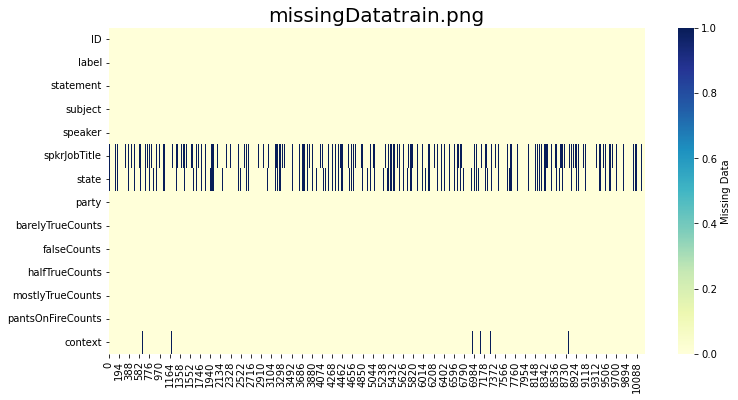

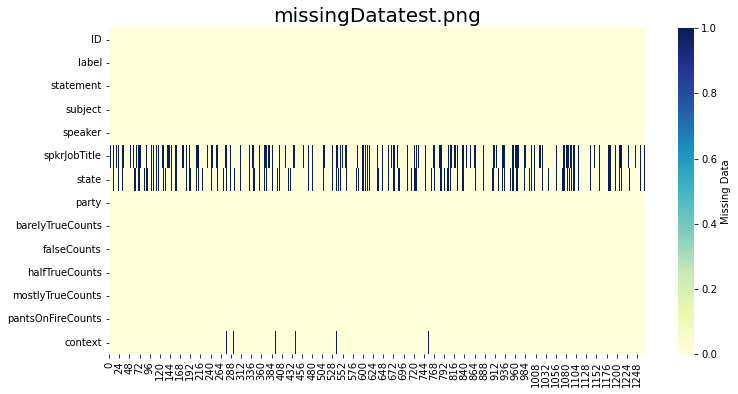

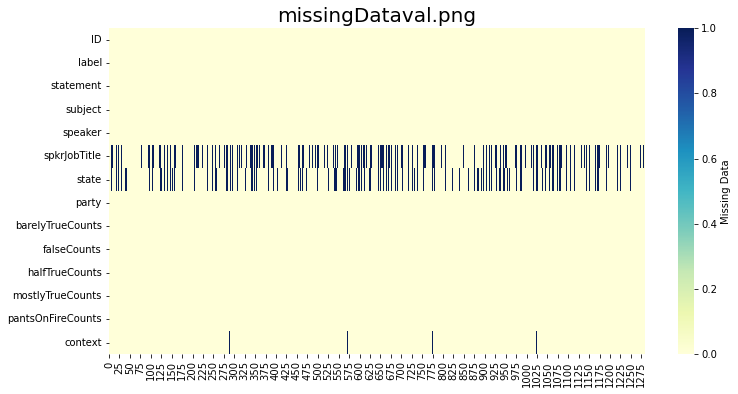

In [6]:
PlotMissingData(train, 'train')
PlotMissingData(test, 'test')
PlotMissingData(val, 'val')

In [7]:
# Count Nulls
trainMissing = train.isnull().sum()
testMissing = test.isnull().sum()
valMissing = val.isnull().sum()

print(trainMissing)
print(testMissing)
print(valMissing)

ID                      0
label                   0
statement               0
subject                 2
speaker                 2
spkrJobTitle         2897
state                2208
party                   2
barelyTrueCounts        2
falseCounts             2
halfTrueCounts          2
mostlyTrueCounts        2
pantsOnFireCounts       2
context               102
dtype: int64
ID                     0
label                  0
statement              0
subject                0
speaker                0
spkrJobTitle         325
state                262
party                  0
barelyTrueCounts       0
falseCounts            0
halfTrueCounts         0
mostlyTrueCounts       0
pantsOnFireCounts      0
context               17
dtype: int64
ID                     0
label                  0
statement              0
subject                0
speaker                0
spkrJobTitle         345
state                279
party                  0
barelyTrueCounts       0
falseCounts            0
halfTrueCo

## 1.3 Check duplicates

In [8]:
def CheckDuplicateIDs(df):
    duplicateIDs = []
    for count in df.ID.value_counts():
        if count > 1:
            duplicateIDs.append(df.ID)
    if duplicateIDs:
        return duplicateIDs
    else:
        return 0

duplicateTrainIDs = CheckDuplicateIDs(train)
duplicateTestIDs = CheckDuplicateIDs(test)
duplicateValIDs = CheckDuplicateIDs(val)
print(f'Duplicates in Train:{duplicateTrainIDs}, Test:{duplicateTestIDs}, Val:{duplicateValIDs}')


Duplicates in Train:0, Test:0, Val:0


## 1.4 Check Quantitative


(array([2114.,    0., 1962.,    0., 1994.,    0., 1676.,    0., 1654.,
         839.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

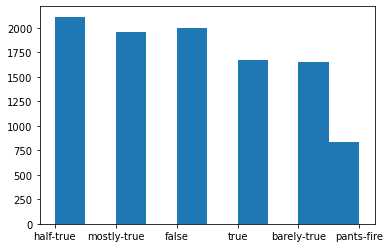

In [9]:
plt.hist(train['label']) # Pants-fire has 750 counts vs. the other classes which have approx 1500-2000 counts.

## 1.5 Check Qualitative

In [10]:
print(f"Unique speakers: {train['speaker'].nunique()} \n")
print(f"Percent unique speakers vs. all train data: {train['speaker'].nunique() / len(train):.2f} \n")
print(train['speaker'].value_counts())

Unique speakers: 2909 

Percent unique speakers vs. all train data: 0.28 

barack-obama                                   488
donald-trump                                   273
hillary-clinton                                239
mitt-romney                                    176
scott-walker                                   149
                                              ... 
kai-degner                                       1
lorraine-fende                                   1
nfederation-o-independent-business-virginia      1
jim-moore                                        1
alan-powell                                      1
Name: speaker, Length: 2909, dtype: int64


# 2 Preprocess 

## 2.1 Get Unique List of Subjects, Contexts, Speakers

In [11]:
listOfSubjects = list(train['subject'])

In [12]:
from collections import defaultdict
import itertools
import operator

def CountListOfList(listOfList):
    countDict = defaultdict(int)
    for subjects in train['subject'].items():
        for subject in subjects:
            countDict[subject] += 1
    sortedCount = dict(sorted(countDict.items(), key=operator.itemgetter(1),reverse=True))

    return sortedCount

<BarContainer object of 20 artists>

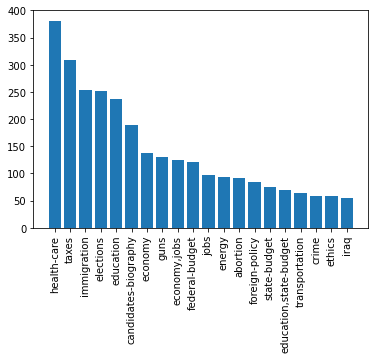

In [13]:
subjects = CountListOfList(listOfSubjects)
top20subjects = dict(itertools.islice(subjects.items(), 20)) # Get top 20 topics
plt.xticks(rotation='vertical')
plt.bar(top20subjects.keys(), top20subjects.values())

## 2.2 Process each statement

In [14]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import numpy as np

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
def RemovePunctuation(sentence: str, punctuations: str) -> str:
    noPunctuation = ""
    for char in sentence:
        if char not in punctuations:
            noPunctuation = noPunctuation + char
    return noPunctuation

In [16]:
def ProcessStatement(statements: List[str], punctuations: str, cachedStopWords: List, snowballStemmer: SnowballStemmer, stem=True) -> List[str]:

    processedStatements = []
    for statement in statements:
        # Make lower case
        _statement = statement.lower()

        # Remove punctuation
        _statement = RemovePunctuation(_statement, punctuations)
        
        # Remove numbers
        _statement  = re.sub('\w*\d\w*', '', _statement) 

        # Split/Tokenise
        _statement = _statement.split(' ') 

        _wordlist = []
        for word in _statement:
            # Exclude stop word. Exclude one-letter words
            if not word in cachedStopWords and len(word) > 1:
                # Stem the word
                if stem:
                    _wordlist.append(snowballStemmer.stem(word))
                else:
                    _wordlist.append(word)
        processedStatements.append(_wordlist)
    
    return processedStatements

In [17]:
cachedStopWords = stopwords.words("english")
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
snowballStemmer = SnowballStemmer('english')

statements = [list(train['statement']), list(val['statement']), list(test['statement'])]

trainWordsStemmed   = ProcessStatement(statements[0], punctuations, cachedStopWords, snowballStemmer, stem=True)
trainWordsUnstemmed = ProcessStatement(statements[0], punctuations, cachedStopWords, snowballStemmer, stem=False)

valWordsStemmed   = ProcessStatement(statements[1], punctuations, cachedStopWords, snowballStemmer, stem=True)
valWordsUnstemmed = ProcessStatement(statements[1], punctuations, cachedStopWords, snowballStemmer, stem=False)

testWordsStemmed    = ProcessStatement(statements[2], punctuations, cachedStopWords, snowballStemmer, stem=True)
testWordsUnstemmed  = ProcessStatement(statements[2], punctuations, cachedStopWords, snowballStemmer, stem=False)

In [18]:
train['wordsStemmed'] = trainWordsStemmed
train['wordsUnstemmed'] = trainWordsUnstemmed
val['wordsStemmed'] = valWordsStemmed
val['wordsUnstemmed'] = valWordsUnstemmed
test['wordsStemmed'] = testWordsStemmed
test['wordsUnstemmed'] = testWordsUnstemmed

## 2.3 One hot encode some of the MetaData

In [19]:
speakerOhe = pd.get_dummies(train['speaker']) 
partyOhe = pd.get_dummies(train['party'])

# 3 Feature Engineering

## 3.1 Embed using Word2Vec

In [21]:
from gensim.models import Word2Vec, KeyedVectors
pretrainedpath = "GoogleNews-vectors-negative300.bin"
w2vModel = KeyedVectors.load_word2vec_format(pretrainedpath,binary=True)
print('done loading Word2Vec')

done loading Word2Vec


In [22]:
def EmbedWords(processedStatements: List[List]) -> List:
    """Averages word embeddings in a sentence to return a word vector"""
    DIMENSION = 300
    zeroVector = np.zeros(DIMENSION)
    wordVectors = []
    excludedWordCount = 0
    excludedWords = []
    totalCount = 0

    for tokens in processedStatements:
        currentVector = zeroVector
        tokenCount = 0
        for token in tokens:
            totalCount += 1
            if token in w2vModel:
                currentVector += w2vModel[token]
                tokenCount += 1
            else:
                excludedWordCount += 1
                excludedWords.append(token)
        wordVectors.append(currentVector/tokenCount)
    return wordVectors, (excludedWords, excludedWordCount/totalCount)

In [23]:
# Need to use unstemmed words to match the words in word2vec "GoogleNews-vectors-negative300.bin" model
trainVec, trainVecLog = EmbedWords(train['wordsUnstemmed']) # 3% of token words excluded. Acceptable.
valVec, valVecLog = EmbedWords(val['wordsUnstemmed']) # 3% of token words excluded. Acceptable.
testVec, testVecLog = EmbedWords(test['wordsUnstemmed']) # 3% of token words excluded. Acceptable.

# 4 Train Multiclass Classifiers

In [24]:
# Randomise rows of data
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)

## 4.1 Baseline Models (Bag of Words)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn import metrics

In [ ]:
def trainBaselineModels(xTrain, yTrain, xVal, yVal, xTest, yTest):
    # Initialise models
    models = [naive_bayes.MultinomialNB(), KNeighborsClassifier(), LogisticRegression(C=1.0, max_iter=10000)]
    modelName = ['NB MultiNomninal', 'KNN', 'Logistic']

    accuracies = []
    for model in models:

        # Fit model on training data and labels
        model.fit(xTrain, yTrain)

        # Predict on test data
        predictions = model.predict(xVal)

        # Check accuracy
        accuracy = metrics.accuracy_score(yVal, predictions)
        accuracies.append(accuracy)

    # Print Accuracy
    for i in range(3):
        print(f'{modelName[i]} Validation accuracy: {accuracies[i]:.2f}')
    print('Choose Logistics because highest validation accuracy')

    # Predict on Test Data
    yPred = model.predict(xTest)
    testAccuracy = metrics.accuracy_score(yTest, yPred)
    print(f'\nPredict on Test Data...accuracy: {testAccuracy:.2f}')
    
    # Evaluate Precision, Recall, F1-Score for Logistic
    print('\n Classification Report for Predictions on Test Data with Logistic Model')
    print(metrics.classification_report(yTest, yPred))

    # Evaluate Confusion Matrix for Logistic
    print('\n Confusion Matrix for Predictions on Test Data with Logistic Model')
    cmDisp = metrics.ConfusionMatrixDisplay.from_predictions(yTest, yPred, xticks_rotation='vertical')


### 4.1.1 CountVectorizer

NB MultiNomninal Validation accuracy: 0.25
KNN Validation accuracy: 0.22
Logistic Validation accuracy: 0.25
Choose Logistics because highest validation accuracy

Predict on Test Data...accuracy: 0.24

 Classification Report for Predictions on Test Data with Logistic Model
              precision    recall  f1-score   support

 barely-true       0.23      0.21      0.22       212
       false       0.27      0.30      0.28       249
   half-true       0.24      0.22      0.23       265
 mostly-true       0.23      0.24      0.24       241
  pants-fire       0.23      0.17      0.20        92
        true       0.24      0.26      0.25       207

    accuracy                           0.24      1266
   macro avg       0.24      0.23      0.24      1266
weighted avg       0.24      0.24      0.24      1266


 Confusion Matrix for Predictions on Test Data with Logistic Model


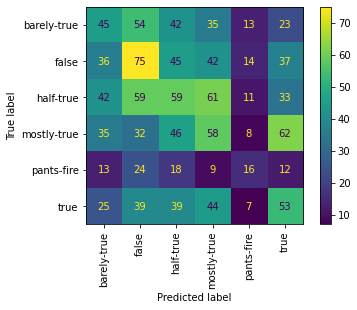

In [ ]:
# Initialise count vectorizer to model 'Bag of Words' with tokenization (keeps punctuation)
countVec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)

# Fit vectorizer to the corpus
countVec.fit(train['statement'])

# Transform training and val statements
xTrain = countVec.transform(train['statement'])
xVal = countVec.transform(val['statement'])
xTest = countVec.transform(test['statement'])

trainBaselineModels(xTrain, train['label'], xVal, val['label'], xTest, test['label'])

### 4.1.2 TfidVectorizer (replaces counts with floats)

NB MultiNomninal Validation accuracy: 0.24
KNN Validation accuracy: 0.22
Logistic Validation accuracy: 0.25
Choose Logistics because highest validation accuracy

Predict on Test Data...accuracy: 0.25

 Classification Report for Predictions on Test Data with Logistic Model
              precision    recall  f1-score   support

 barely-true       0.25      0.18      0.21       212
       false       0.28      0.35      0.31       249
   half-true       0.22      0.29      0.25       265
 mostly-true       0.24      0.25      0.25       241
  pants-fire       0.36      0.04      0.08        92
        true       0.27      0.25      0.26       207

    accuracy                           0.25      1266
   macro avg       0.27      0.23      0.23      1266
weighted avg       0.26      0.25      0.24      1266


 Confusion Matrix for Predictions on Test Data with Logistic Model


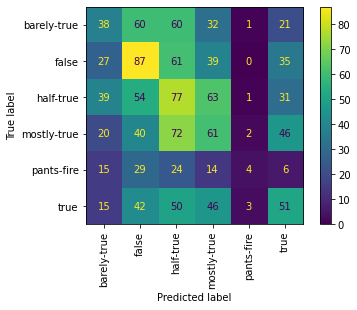

In [ ]:
# Initialise count vectorizer to model 'Bag of Words' with tokenization (keeps punctuation)
tfv = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)

# Fit vectorizer to the corpus
tfv.fit(train['statement'])

# Transform training and val statements
xTrain = tfv.transform(train['statement'])
xVal= tfv.transform(val['statement'])
xTest = tfv.transform(test['statement'])

trainBaselineModels(xTrain, train['label'], xVal, val['label'], xTest, test['label'])

### 4.1.3 Ngram range 1 to 3

NB MultiNomninal Validation accuracy: 0.24
KNN Validation accuracy: 0.25
Logistic Validation accuracy: 0.26
Choose Logistics because highest validation accuracy

Predict on Test Data...accuracy: 0.25

 Classification Report for Predictions on Test Data with Logistic Model
              precision    recall  f1-score   support

 barely-true       0.27      0.14      0.19       212
       false       0.28      0.35      0.31       249
   half-true       0.23      0.37      0.29       265
 mostly-true       0.23      0.28      0.25       241
  pants-fire       0.00      0.00      0.00        92
        true       0.26      0.17      0.21       207

    accuracy                           0.25      1266
   macro avg       0.21      0.22      0.21      1266
weighted avg       0.24      0.25      0.23      1266


 Confusion Matrix for Predictions on Test Data with Logistic Model


C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

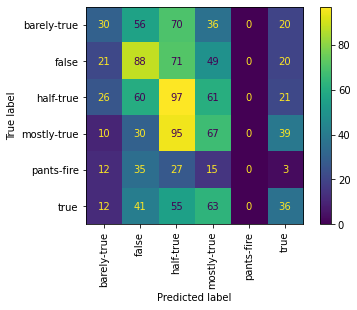

In [ ]:
# Initialise count vectorizer to model 'Bag of Words' with tokenization (keeps punctuation). Specifically try ngrams ranges 1 to 3
tfv = TfidfVectorizer(tokenizer=word_tokenize,token_pattern=None,ngram_range=(1, 3))

# Fit vectorizer to the corpus
tfv.fit(train['statement'])

# Transform training and val statements
xTrain = tfv.transform(train['statement'])
xVal = tfv.transform(val['statement'])
xTest = tfv.transform(test['statement'])

trainBaselineModels(xTrain, train['label'], xVal, val['label'], xTest, test['label'])

## 4.2 Use Baseline Models but with Word2Vec Instead

Models: Logistic, KNN
Accuracy = 0.18
Accuracy = 0.18
Choose Logistics because highest validation accuracy

Predict on Test Data...accuracy: 0.19

 Classification Report for Predictions on Test Data with Logistic Model
              precision    recall  f1-score   support

 barely-true       0.15      0.29      0.20       212
       false       0.21      0.16      0.18       249
   half-true       0.22      0.20      0.21       265
 mostly-true       0.21      0.21      0.21       241
  pants-fire       0.08      0.02      0.03        92
        true       0.21      0.18      0.20       207

    accuracy                           0.19      1266
   macro avg       0.18      0.18      0.17      1266
weighted avg       0.19      0.19      0.19      1266


 Confusion Matrix for Predictions on Test Data with Logistic Model


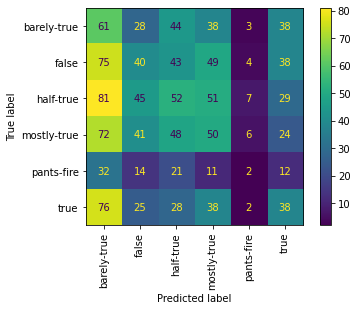

In [ ]:
# Use the Word2Vec embedding created earlier. Note: NaiveBayes doesn't work with negative numbers
models = [LogisticRegression(C=1.0, max_iter=10000), KNeighborsClassifier()]
print(f'Models: Logistic, KNN')

for model in models:

    # Fit model on training data and labels
    model.fit(trainVec, train['label'])

    # Evaluate on val data
    predictions = model.predict(valVec)

    # Check accuracy
    accuracy = metrics.accuracy_score(val['label'], predictions)
    print(f"Accuracy = {accuracy:.2f}")

print('Choose Logistics because highest validation accuracy')

# Predict on Test Data
yPred = model.predict(testVec)
testAccuracy = metrics.accuracy_score(test['label'], yPred)
print(f'\nPredict on Test Data...accuracy: {testAccuracy:.2f}')

# Evaluate Precision, Recall, F1-Score for Logistic
print('\n Classification Report for Predictions on Test Data with Logistic Model')
print(metrics.classification_report(test['label'], yPred))

# Evaluate Confusion Matrix for Logistic
print('\n Confusion Matrix for Predictions on Test Data with Logistic Model')
cmDisp = metrics.ConfusionMatrixDisplay.from_predictions(test['label'], yPred, xticks_rotation='vertical')

# 4.3 Deep learning: LSTM Model
For word embeddings use one of the following options: embedding layer in Keras, Word2Vec, GloVE. You have the freedom to pick your own deep learning architecture.
- Most common architectures are CNNs and RNNs. LSTMs are a popular form of RNN.
- LSTMs are popular because they handle sequential data whereas CNNs don't.
- Recent approachs also involve starting with large, pre-trained language model and fine-tuning them for the task at hand.

In [25]:
import keras
import tensorflow
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # This is now fully integrated into tensorflow
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Embedding, LSTM
from keras.models import Sequential
from keras import layers

### 4.3.1 Word Embedding for LSTM
1. tokenise the texts and convert into word index vectors
1. Pad the text sequence so that all texts are the same length
1. Map every word index to an embedding vector by multiplying word index vectors with the embedding matrix (pre-trained embeddings or custom embedding)

In [78]:
# Set train, test, val input data [Processed Statements: no punctuation, no stop words]
_xTrain = train['wordsUnstemmed'].head(500)
_xTest = test['wordsUnstemmed'].head(500)
_xVal = val['wordsUnstemmed'].head(500)

_yTrain = train['label'].head(500)
_yTest = test['label'].head(500)
_yVal = val['label'].head(500)

# Sanity Check input data
print(_xTrain.head(), _yTrain.head())
print(_xTest.head(), _yTest.head())
print(_xVal.head(), _yVal.head())

0    [state, support, local, schools, per, pupil, d...
1    [twentythree, million, americans, suffer, addi...
2    [says, president, barack, obama, gone, texasme...
3    [privatesector, jobs, created, first, eight, m...
4    [spend, percent, entire, cost, military, aspec...
Name: wordsUnstemmed, dtype: object 0      half-true
1    mostly-true
2          false
3      half-true
4      half-true
Name: label, dtype: object
0    [gov, romneys, plan, would, cut, taxes, folks,...
1    [percent, virginians, minimum, wage, earners, ...
2    [people, tiverton, historically, supported, ga...
3    [says, percent, food, stamp, benefits, paid, p...
4    [received, ratings, every, conservative, organ...
Name: wordsUnstemmed, dtype: object 0    mostly-true
1    mostly-true
2           true
3           true
4    mostly-true
Name: label, dtype: object
0    [says, mark, warner, told, politifact, nationa...
1    [roughly, georgians, die, needlessly, year, fa...
2    [says, eliminated, epa, rule, treated, 

In [79]:
# Define constants for the LSTM
# MARGIN = 1
# # maxStatement = max(train['statement'].max(), test['statement'].max())
# MAX_SEQUENCE_LENGTH = len(maxStatement) * MARGIN
# MAX_NUM_WORDS = len(maxStatement.split()) * MARGIN
# EMBEDDING_DIM = 100
# print(f'Longest statement: {maxStatement}')
# print(f'Max sequence length: {len(maxStatement)}, Max words: {len(maxStatement.split())}')
# print(f'MAX_SEQUENCE_LENGTH: {MAX_SEQUENCE_LENGTH}, MAX_NUM_WORDS: {MAX_NUM_WORDS}')

MAX_SEQUENCE_LENGTH = 500
MAX_NUM_WORDS = 200
EMBEDDING_DIM = 100

In [80]:
# Convert labels from categoricals to one hot encoded columns
le = LabelEncoder()
le.fit(train['label'])
labelMap = dict(zip(le.classes_, le.transform(le.classes_))) 
print(f'Label Map: {labelMap}')

# Convert String labels to Integers
yTrainIntClass = le.transform(_yTrain)
yTestIntClass = le.transform(_yTest)
yValIntClass = le.transform(_yVal)
labelMapIntAsKey = {value:key for key, value in labelMap.items()} # Make integer keys and strings the values. Used in metrics

# Convert to OHE
NUM_CLASSES = len(labelMap)
yTrain = to_categorical(yTrainIntClass, NUM_CLASSES)
yTest = to_categorical(yTestIntClass, NUM_CLASSES)
yVal = to_categorical(yValIntClass, NUM_CLASSES)

print(yTrain, yTest, yVal)

Label Map: {'barely-true': 0, 'false': 1, 'half-true': 2, 'mostly-true': 3, 'pants-fire': 4, 'true': 5}
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]] [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]] [[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [81]:
# Create Word Index
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token=1)
tokenizer.fit_on_texts(train['statement'])
trainSequences = tokenizer.texts_to_sequences(_xTrain)
testSequences = tokenizer.texts_to_sequences(_xTest)
valSequences = tokenizer.texts_to_sequences(_xVal)
wordIndex = tokenizer.word_index

# Pad sequences with zeros until max sequence length
trainData = pad_sequences(trainSequences, maxlen=MAX_SEQUENCE_LENGTH) 
testData = pad_sequences(testSequences, maxlen=MAX_SEQUENCE_LENGTH)
valData = pad_sequences(valSequences, maxlen=MAX_SEQUENCE_LENGTH)

# Sanity check
print(valData)
print(testData)
print(trainData)

[[  0   0   0 ...   0   7  31]
 [  0   0   0 ...   0   0  31]
 [  0   0   0 ...   7 194 181]
 ...
 [  0   0   0 ...   0   0 116]
 [  0   0   0 ...   0 132  77]
 [  0   0   0 ...   0   0   7]]
[[  0   0   0 ...  39 103  71]
 [  0   0   0 ...   0  14  33]
 [  0   0   0 ...  35  98  21]
 ...
 [  0   0   0 ... 144  33  98]
 [  0   0   0 ...  91 120  33]
 [  0   0   0 ...   0   0   0]]
[[  0   0   0 ...  21 151  14]
 [  0   0   0 ...  40 109 108]
 [  0   0   0 ...  34  78  27]
 ...
 [  0   0   0 ...   7 140  37]
 [  0   0   0 ...  34  78  27]
 [  0   0   0 ... 123 101  95]]


In [52]:
# Use Stanford Glove to create
embeddingDict = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        embeddingDict[word] = np.asarray(values[1:], dtype='float32')
        numWords = min(MAX_NUM_WORDS, len(wordIndex)) + 1
        embeddingMatrix = np.zeros((numWords, EMBEDDING_DIM))
        
for word, i in wordIndex.items():
    if i > MAX_NUM_WORDS:
        continue
    embeddingVec = embeddingDict.get(word)
    if embeddingVec is not None:
        embeddingMatrix[i] = embeddingVec

In [56]:
print(embeddingMatrix.shape)

(201, 100)


In [41]:
# Create Embedding Layer
embeddingLayer = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, embeddings_initializer=Constant(embeddingMatrix), input_length=MAX_SEQUENCE_LENGTH, trainable=False)

## 4.3.2 Create Deep Learning Model
You have the freedom to pick your own deep learning architecture.

In [31]:
# Set up plots
def PlotHistory(model):
    plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [35]:
from sklearn import metrics
def EvalDeepLearningModel(myLSTM, xTest, yTest, labelMap):
    # Predict on training data
    yPred = myLSTM.predict(xTest)

    # Preproces back to class labels
    yPredRounded =np.argmax(yPred, axis=1) # Convert from OHE back to single column of integers
    yTestRounded = np.argmax(yTest, axis=1) # Convert from OHE back to single column of  integers
    yPredString = [labelMapIntAsKey[integerLabel] for integerLabel in yPredRounded] # Convert labels from intergers to strings
    yTestString = [labelMapIntAsKey[integerLabel] for integerLabel in yTestRounded] # Convert labels from intergers to strings

    # Evaluate Confusion Matrix
    cm = metrics.confusion_matrix(yTestString, yPredString)
    cmDisp = metrics.ConfusionMatrixDisplay(cm, display_labels=[values for key, values in labelMap.items()])
    cmDisp.plot()

    # Evaluate Precision, Recall, F1-Score
    print(metrics.classification_report(yTestString, yPredString))

    # ROC is for binary classification. So we need to use One vs. One and One vs. Rest for multiclass classification.
    # Note: ROC for multi-class can be macro or weighted since we need to effectively collapse the ROCs for each label into one metric.
    # Good 0.8-0.9. Acceptable 0.7-0.8. Bad < 0.5.
    macroAUC_OVO = metrics.roc_auc_score(yTest, yPred, multi_class="ovo", average="macro")
    weightedAUC_OVO = metrics.roc_auc_score(yTest, yPred, multi_class="ovo", average="weighted")
    print(f'Macro AUC OVO : {macroAUC_OVO:.3f}, Weighted AUC OVO: {weightedAUC_OVO:.3f}')

    macroAUC_OVR = metrics.roc_auc_score(yTest, yPred, multi_class="ovr", average="macro")
    weightedAUC_OVR = metrics.roc_auc_score(yTest, yPred, multi_class="ovr", average="weighted")
    print(f'Macro AUC OVR : {macroAUC_OVR:.3f}, Weighted AUC OVR: {weightedAUC_OVR:.3f}')

## 4.3.3. Basic Architecture

In [83]:
# Create Deep Learning Network BASIC
myLSTM0 = Sequential()
myLSTM0.add(Embedding(MAX_NUM_WORDS, 128))
myLSTM0.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
myLSTM0.add(Dense(6, activation='sigmoid'))
myLSTM0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train The Model
print('\nTraining the model...')
resultBasic = myLSTM0.fit(trainData, yTrain, batch_size=32, epochs=1, validation_data=(valData, yVal))

# Check Accuracy on Test
score, acc = myLSTM0.evaluate(testData, yTest, batch_size=32)
print('\nTesting Model...')
print(f'LSTM predication accuracy on Test Data: {acc:.2f}')


Training the model...
16/16 [==============================] - 5s 342ms/step - loss: 1.7423 - accuracy: 0.2220

Testing Model...
LSTM predication accuracy on Test Data: 0.22


In [84]:
# Sanity check prediction
new_statement = list(val['statement'].head(1))
print(new_statement)

seq = tokenizer.texts_to_sequences(new_statement)
print(seq)

processedStatement = list(val['wordsUnstemmed'].head(1))
print(processedStatement)

seq2 = tokenizer.texts_to_sequences(processedStatement)
print(seq2)

padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
print(padded)

pred = myLSTM0.predict(padded)
print(pred)

['Says Mark Warner told PolitiFact Nationals Lie of the Year in 2013.']
[[7, 3, 1, 31, 2]]
[['says', 'mark', 'warner', 'told', 'politifact', 'nationals', 'lie', 'year']]
[[7, 31]]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  

C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00        90
       false       0.00      0.00      0.00        94
   half-true       0.22      1.00      0.36       111
 mostly-true       0.00      0.00      0.00        93
  pants-fire       0.00      0.00      0.00        24
        true       0.00      0.00      0.00        88

    accuracy                           0.22       500
   macro avg       0.04      0.17      0.06       500
weighted avg       0.05      0.22      0.08       500

Macro AUC OVO : 0.499, Weighted AUC OVO: 0.503
Macro AUC OVR : 0.499, Weighted AUC OVR: 0.503


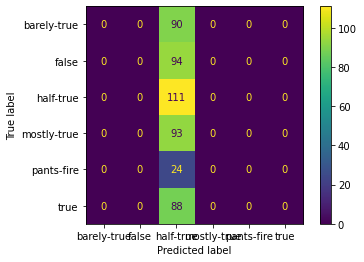

In [85]:
EvalDeepLearningModel(myLSTM0, testData, yTest, labelMapIntAsKey)

In [ ]:
# Create Deep Learning Network
myLSTM1 = Sequential()
myLSTM1.add(Embedding(MAX_NUM_WORDS, 128))
myLSTM1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
myLSTM1.add(Dense(20, activation='sigmoid'))
myLSTM1.add(Dense(6, activation='sigmoid'))
myLSTM1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train The Model
print('\nTraining the model...')
result = myLSTM1.fit(trainData, yTrain, batch_size=32, epochs=3, validation_data=(valData, yVal))

# Check Accuracy on Test
score, acc = myLSTM1.evaluate(testData, yTest, batch_size=32)
print('\nTesting Model...')
print(f'LSTM predication accuracy on Test Data: {acc:.2f}')


Training the model...
Epoch 1/3


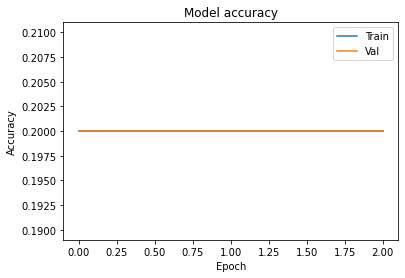

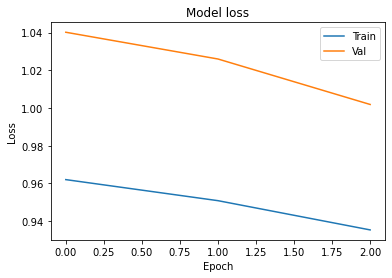

In [ ]:
PlotHistory(result)

# 5 Hyperparameter tuning
In machine learning, hyperparameter tuning is the problem of choosing a set of optimal
hyperparameters for a learning algorithm. In this step, select one or two parameters and
optimise them to further improve the performance of your LSTM model.

## 5.1 Change number of epochs from 3 to 7

In [ ]:
# Create Deep Learning Network
myLSTM2 = Sequential()
myLSTM2.add(Embedding(MAX_NUM_WORDS, 128))
myLSTM2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
myLSTM2.add(Dense(20, activation='sigmoid'))
myLSTM2.add(Dense(6, activation='sigmoid'))
myLSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train The Model
print('\nTraining the model...')
resultEpochChange = myLSTM2.fit(trainData, yTrain, batch_size=32, epochs=7, validation_data=(valData, yVal))

# Check Accuracy on Test
score, acc = myLSTM2.evaluate(testData, yTest, batch_size=32)
print('\nTesting Model...')
print(f'LSTM predication accuracy on Test Data: {acc:.2f}')


Training the model...
Epoch 1/7
320/320 [==============================] - 885s 3s/step - loss: 0.4620 - accuracy: 0.1897 - val_loss: 0.4452 - val_accuracy: 0.1933
Epoch 2/7
320/320 [==============================] - 861s 3s/step - loss: 0.4440 - accuracy: 0.2009 - val_loss: 0.4453 - val_accuracy: 0.1933
Epoch 3/7
320/320 [==============================] - 873s 3s/step - loss: 0.4439 - accuracy: 0.2050 - val_loss: 0.4452 - val_accuracy: 0.1933
Epoch 4/7
320/320 [==============================] - 870s 3s/step - loss: 0.4440 - accuracy: 0.1993 - val_loss: 0.4449 - val_accuracy: 0.1933
Epoch 5/7
320/320 [==============================] - 861s 3s/step - loss: 0.4440 - accuracy: 0.1992 - val_loss: 0.4447 - val_accuracy: 0.1933
Epoch 6/7
320/320 [==============================] - 860s 3s/step - loss: 0.4439 - accuracy: 0.2024 - val_loss: 0.4452 - val_accuracy: 0.1933
Epoch 7/7
40/40 [==============================] - 9s 226ms/step - loss: 0.4424 - accuracy: 0.2093

Testing Model...
LSTM pre

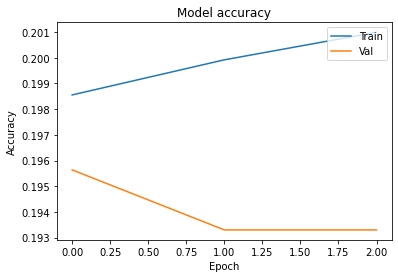

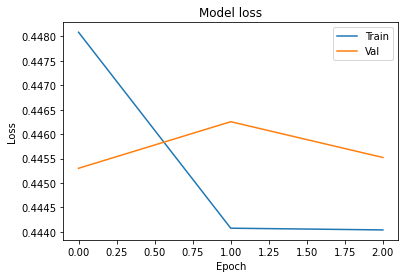

In [ ]:
PlotHistory(resultEpochChange)

## 5.2 Change batch size from 32 to 100

In [ ]:
# Create Deep Learning Network
myLSTM3 = Sequential()
myLSTM3.add(Embedding(MAX_NUM_WORDS, 128))
myLSTM3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
myLSTM3.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
myLSTM3.add(Dense(20, activation='sigmoid'))
myLSTM3.add(Dense(6, activation='sigmoid'))
myLSTM3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train The Model
print('\nTraining the model...')
resultBatchChange = myLSTM3.fit(trainData, yTrain, batch_size=100, epochs=7, validation_data=(valData, yVal))

# Check Accuracy on Test
score, acc = myLSTM3.evaluate(testData, yTest, batch_size=32)
print('\nTesting Model...')
print(f'LSTM predication accuracy on Test Data: {acc:.2f}')


Training the model...
Epoch 1/7
 55/103 [===============>..............] - ETA: 2:28 - loss: 0.5498 - accuracy: 0.1993

KeyboardInterrupt: 

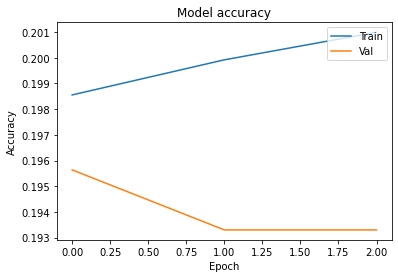

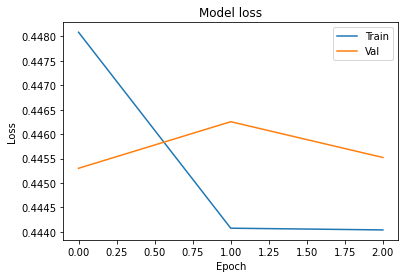

In [ ]:
PlotHistory(resultBatchChange)

# 6 Model Evaluation

## 6.1 Use metrics such as precision, recall, F-measure and AUC to evaluate the performance of your models.

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (6).

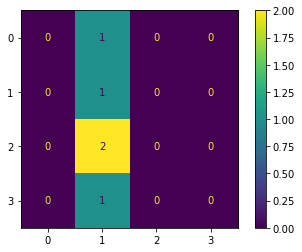

In [ ]:
EvalDeepLearningModel(myLSTM1, testData, yTest, labelMapIntAsKey)

C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00       212
       false       0.00      0.00      0.00       249
   half-true       0.21      1.00      0.35       265
 mostly-true       0.00      0.00      0.00       241
  pants-fire       0.00      0.00      0.00        92
        true       0.00      0.00      0.00       207

    accuracy                           0.21      1266
   macro avg       0.03      0.17      0.06      1266
weighted avg       0.04      0.21      0.07      1266

Macro AUC OVO : 0.500, Weighted AUC OVO: 0.501
Macro AUC OVR : 0.500, Weighted AUC OVR: 0.501


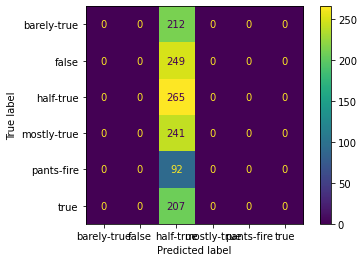

In [ ]:
EvalDeepLearningModel(myLSTM2, testData, yTest, labelMapIntAsKey)

              precision    recall  f1-score   support

 barely-true       0.00      0.00      0.00       212
       false       0.20      1.00      0.33       249
   half-true       0.00      0.00      0.00       265
 mostly-true       0.00      0.00      0.00       241
  pants-fire       0.00      0.00      0.00        92
        true       0.00      0.00      0.00       207

    accuracy                           0.20      1266
   macro avg       0.03      0.17      0.05      1266
weighted avg       0.04      0.20      0.06      1266

Macro AUC OVO : 0.490, Weighted AUC OVO: 0.494
Macro AUC OVR : 0.490, Weighted AUC OVR: 0.494


C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jason\anaconda3\envs\uni_adelaide_keras\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

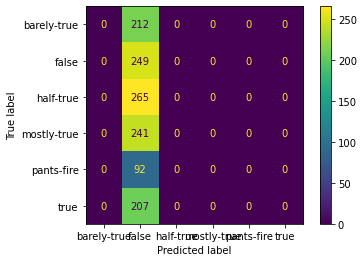

In [ ]:
EvalDeepLearningModel(myLSTM3, testData, yTest, labelMapIntAsKey)

# 7 Conclusion